# Results Visualization

This notebook visualizes the results from the experiments comparing different survival models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from lifelines import KaplanMeierFitter

In [2]:
# ===============================
# Configuration
# ===============================
DATASETS = ["aids", "breast_cancer","gbsg", "metabric", "pbc", "tcga_brca", "veterans", "whas"]

EVENT_COL = "event"
TIME_COL = "time"

# Create mapping for prettier model names
model_name_mapping = {
    'coxph': 'CoxPH',
    'aft': 'AFT',
    'pchazard': 'PC-Hazard',
    'logistic_hazard': 'LOG-Hazard',
    'survival_forest': 'RSF',
    'xgbcox': 'XGBCox',
    'deepsurv': 'DeepSurv',
    'deephit': 'DeepHit',
    'sca': 'SCA',
    'vadesc': 'VADeSC',
    'dcm': 'DCM',
    'dvcsurv': 'DVCSurv',
    'converse_siamese': 'CONVERSE-Siamese',
    'converse_single': 'CONVERSE-Single'
}

# Rename columns (datasets) for display
dataset_name_mapping = {
    'aids': 'AIDS',
    'breast_cancer': 'BREAST',
    'gbsg': 'GBSG',
    'metabric': 'METABRIC',
    'pbc': 'PBC',
    'tcga_brca': 'TCGA-BRCA',
    'veterans': 'VETERANS',
    'whas': 'WHAS'
}

## Load Data

In [3]:
# Find all CSV files without any date and time and "detailed" in their names and read them into a single DataFrame
csv_pattern = '../results/*.csv'
csv_files = sorted(glob.glob(csv_pattern))
csv_files = [f for f in csv_files if "detailed" not in f and not any(char.isdigit() for char in f)]

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# Apply display mappings once and reuse everywhere else
data['model_display'] = data['model'].map(model_name_mapping).fillna(data['model'])
data['dataset_display'] = data['dataset'].map(dataset_name_mapping).fillna(data['dataset'])

print(f"Total models found: {sorted(data['model'].unique())}")
print(f"Total datasets found: {sorted(data['dataset'].unique())}")

Total models found: ['aft', 'converse_siamese', 'converse_single', 'coxph', 'dcm', 'deephit', 'deepsurv', 'dvcsurv', 'logistic_hazard', 'pchazard', 'sca', 'survival_forest', 'vadesc', 'xgbcox']
Total datasets found: ['aids', 'breast_cancer', 'gbsg', 'metabric', 'pbc', 'tcga_brca', 'veterans', 'whas']


### Analysis of Data

In [4]:
# Dataset summary table: Dataset name, #Samples, #Features, Censoring rate (%)
dataset_rows = []

for dataset in DATASETS:
    df_raw = pd.read_csv(f'../survbase/datasets/{dataset}.csv')

    if EVENT_COL not in df_raw.columns:
        raise ValueError(f"Column '{EVENT_COL}' not found in dataset '{dataset}'.")

    if TIME_COL not in df_raw.columns:
        raise ValueError(f"Column '{TIME_COL}' not found in dataset '{dataset}'.")

    # Convert event indicator to binary (1=event, 0=censored)
    event_series = df_raw[EVENT_COL]
    event_num = pd.to_numeric(event_series, errors='coerce')

    if event_num.isna().all():
        event_map = {
            'true': 1, 'false': 0,
            'yes': 1, 'no': 0,
            'event': 1, 'censored': 0,
            'dead': 1, 'alive': 0
        }
        event_num = event_series.astype(str).str.strip().str.lower().map(event_map)

    if event_num.isna().any():
        raise ValueError(f"Could not fully parse event values for dataset '{dataset}' in column '{EVENT_COL}'.")

    censoring_rate = (1 - event_num.astype(float).mean()) * 100

    feature_exclude = {EVENT_COL, TIME_COL}
    n_features = len([c for c in df_raw.columns if c not in feature_exclude])

    dataset_rows.append({
        'Dataset name': dataset_name_mapping.get(dataset, dataset),
        '#Samples': int(len(df_raw)),
        '#Features': int(n_features),
        'Censoring rate (%)': round(float(censoring_rate), 2)
    })

dataset_table = pd.DataFrame(dataset_rows)
dataset_table = dataset_table.sort_values('Dataset name').reset_index(drop=True)
dataset_table

,Dataset name,#Samples,#Features,Censoring rate (%)
0,AIDS,1151,11,91.66
1,BREAST,198,80,74.24
2,GBSG,686,8,56.41
3,METABRIC,1904,9,42.07
4,PBC,312,6,59.94
5,TCGA-BRCA,1088,39,86.12
6,VETERANS,137,6,6.57
7,WHAS,461,16,61.82


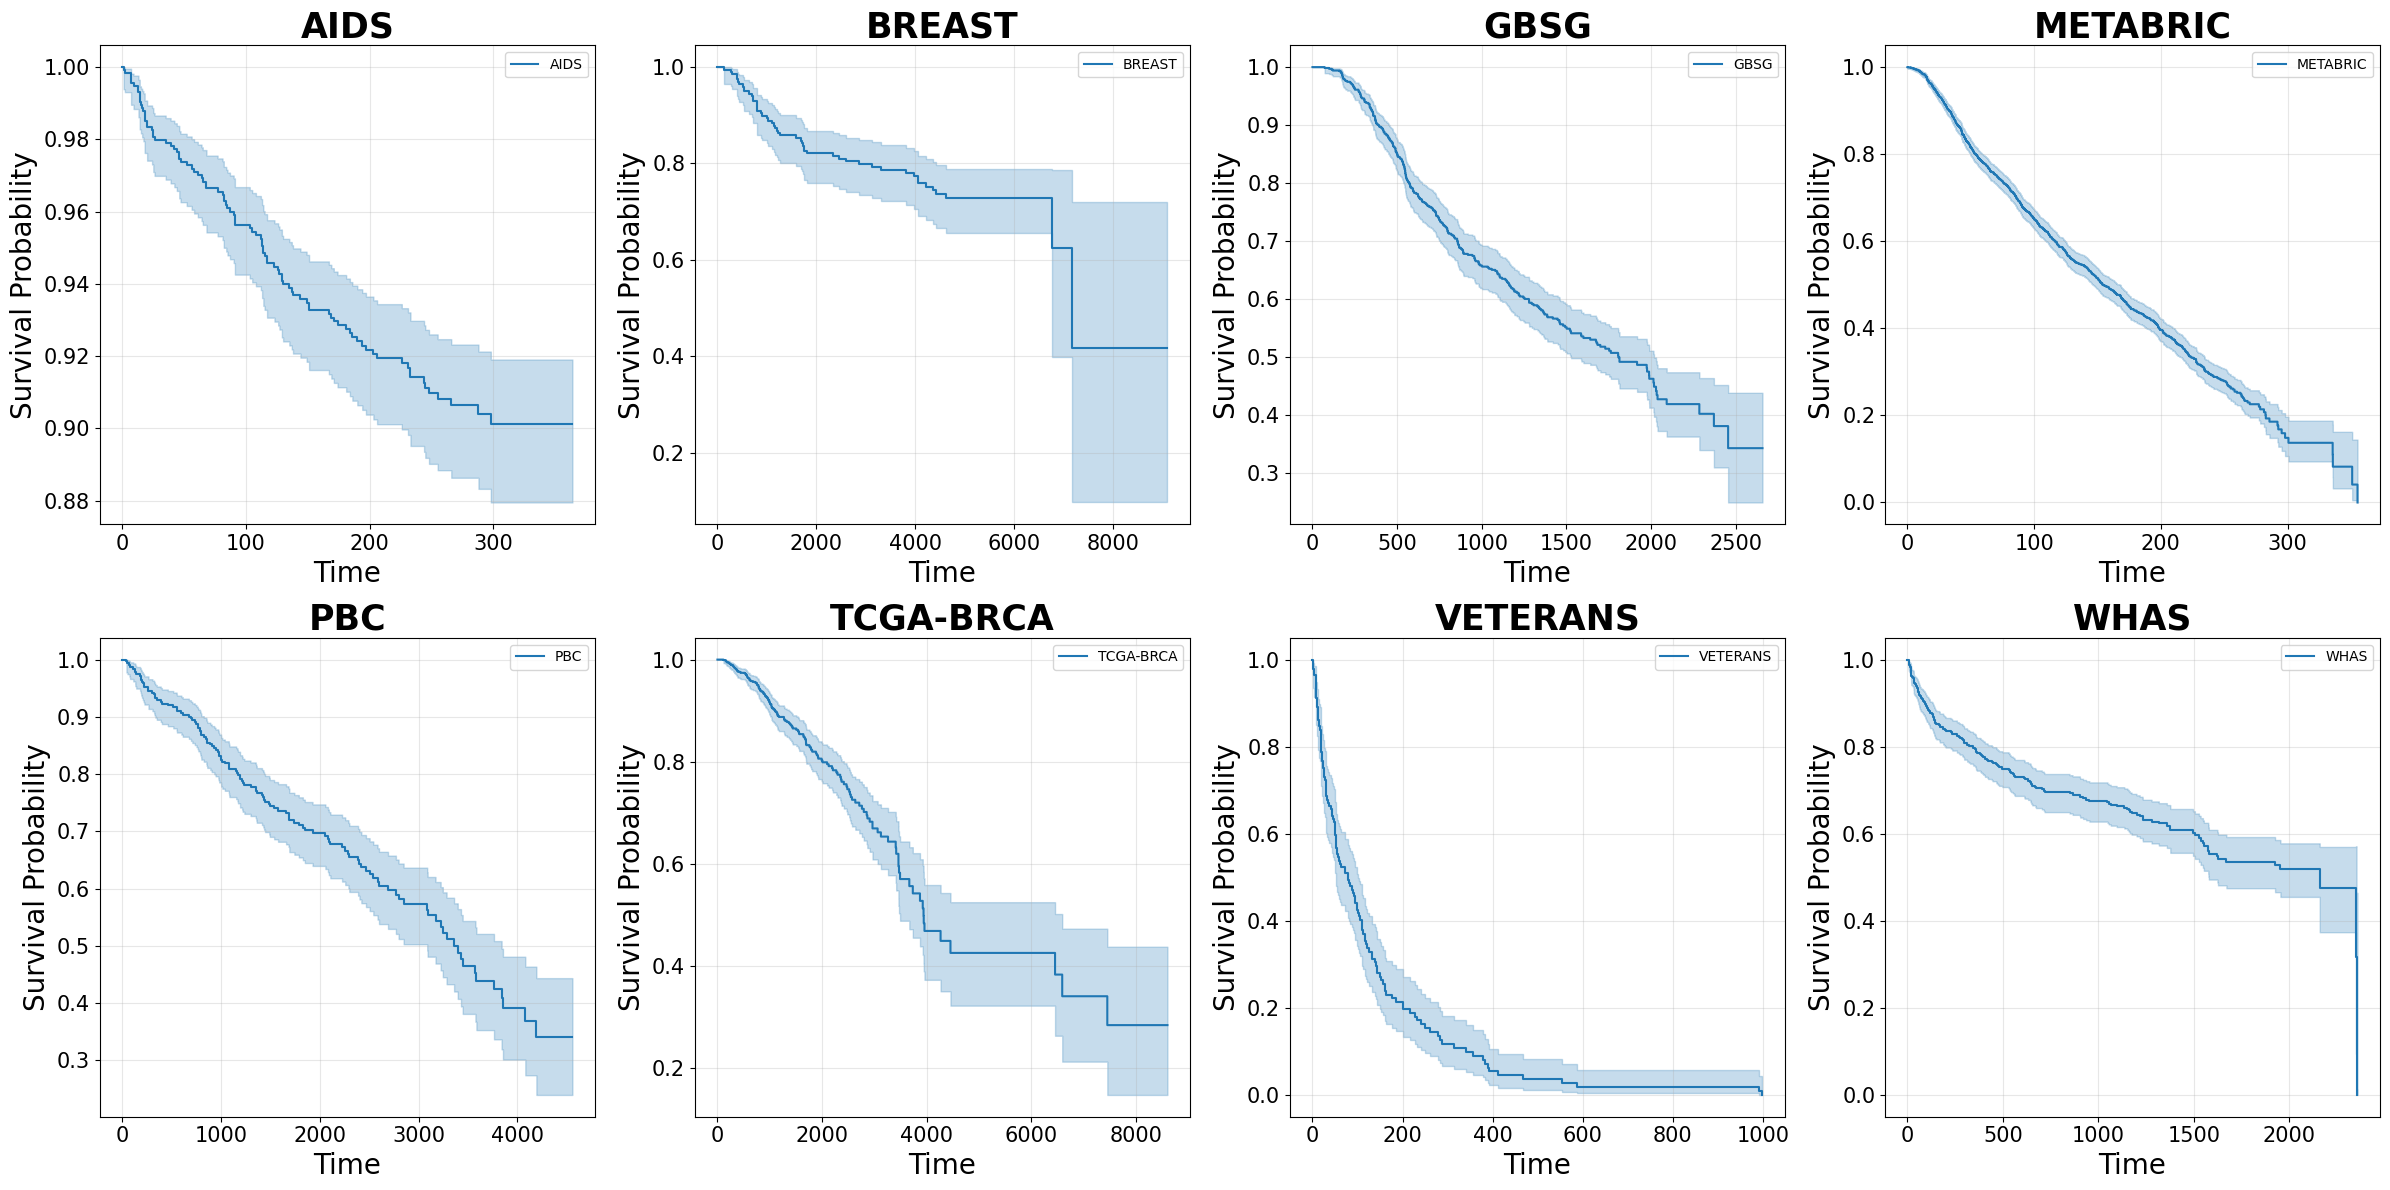

In [5]:
# Kaplan-Meier curves across datasets (2x4 layout)
def _to_event_indicator(series):
    event_num = pd.to_numeric(series, errors='coerce')
    if event_num.isna().all():
        event_map = {
            'true': 1, 'false': 0,
            'yes': 1, 'no': 0,
            'event': 1, 'censored': 0,
            'dead': 1, 'alive': 0
        }
        event_num = series.astype(str).str.strip().str.lower().map(event_map)
    if event_num.isna().any():
        raise ValueError('Could not fully parse event indicator values.')
    return event_num.astype(int)


n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 12))
axes = axes.flatten()

for idx, dataset in enumerate(DATASETS):
    df_raw = pd.read_csv(f'../survbase/datasets/{dataset}.csv')

    if EVENT_COL not in df_raw.columns:
        raise ValueError(f"Column '{EVENT_COL}' not found in dataset '{dataset}'.")
    if TIME_COL not in df_raw.columns:
        raise ValueError(f"Column '{TIME_COL}' not found in dataset '{dataset}'.")

    df = pd.DataFrame({
        'time': pd.to_numeric(df_raw[TIME_COL], errors='coerce'),
        'event': _to_event_indicator(df_raw[EVENT_COL])
    }).dropna()

    if df.empty:
        raise ValueError(f"No valid time/event rows for dataset '{dataset}'.")

    display_name = dataset_name_mapping.get(dataset, dataset)

    # Fit Kaplan-Meier
    kmf = KaplanMeierFitter()
    kmf.fit(df['time'], df['event'], label=display_name)

    # Plot on subplot
    ax = axes[idx]
    kmf.plot_survival_function(ax=ax, ci_show=True)
    ax.set_title(f'{display_name}', fontsize=25, fontweight='bold')
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('Survival Probability', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

## C-Index Comparison Across Models

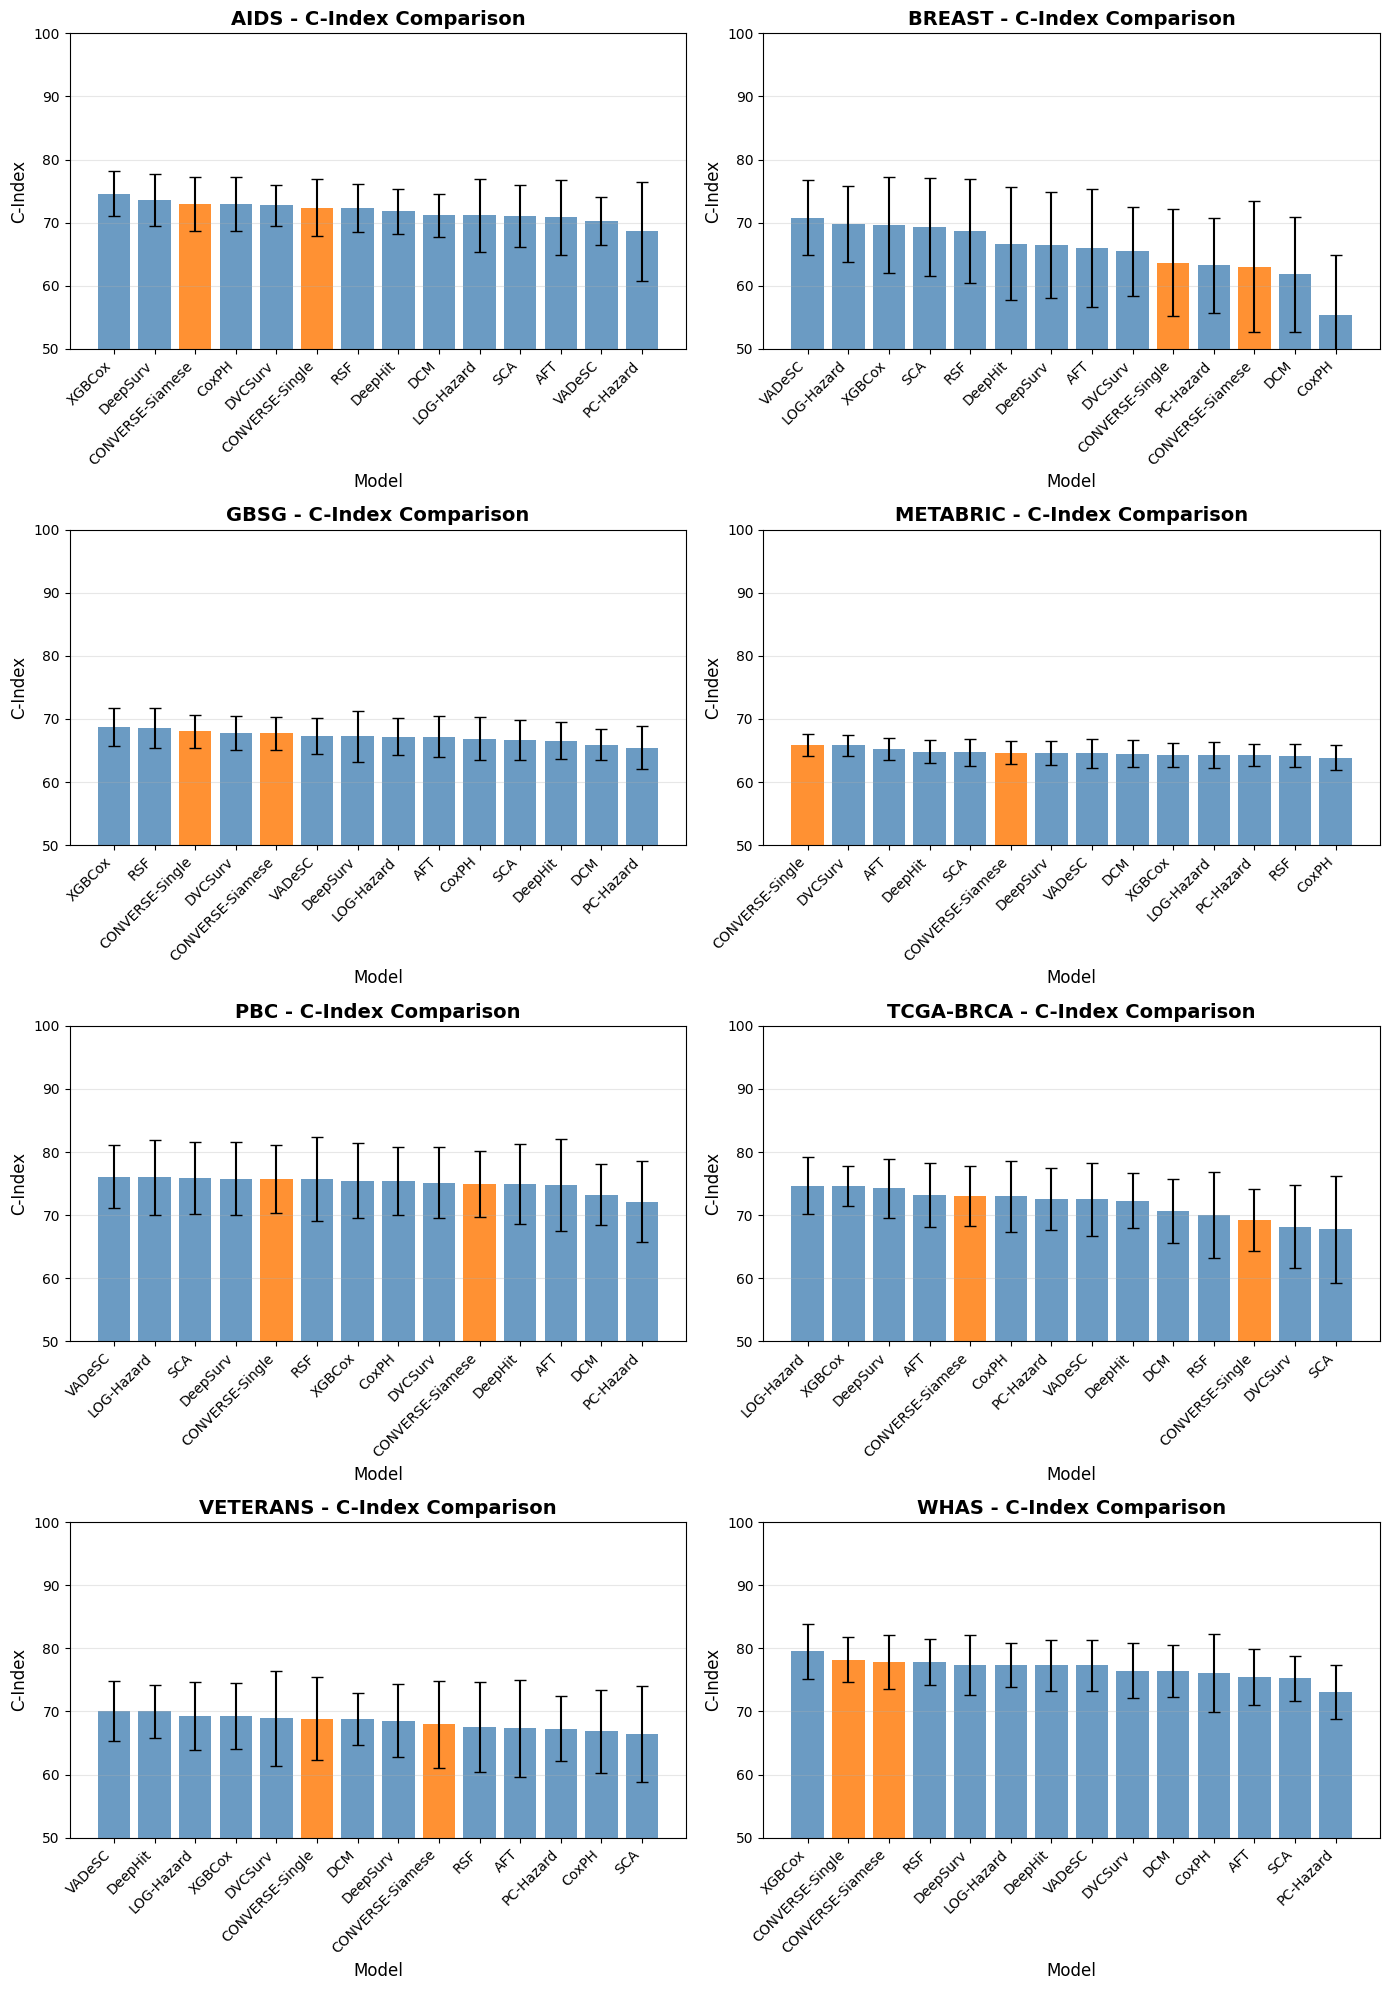

In [6]:
# C-Index comparison: separate plots for each dataset (4x2 layout) for test performance only
datasets = sorted(data['dataset'].unique())

n_cols = 2
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 20))
axes = axes.flatten()

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    df_subset = data[data['dataset'] == dataset].copy()

    # Sort models by test C-index performance (descending)
    df_subset = df_subset.sort_values('test_cindex_mean', ascending=False)

    raw_models = df_subset['model'].values
    display_models = df_subset['model_display'].values
    dataset_label = df_subset['dataset_display'].iloc[0]

    x_pos = np.arange(len(display_models))

    # Color bars: converse models in orange, others in steelblue
    colors = ['#ff7600' if m in ['converse_single', 'converse_siamese'] else 'steelblue' for m in raw_models]

    # Plot test performance only (scaled by 100)
    ax.bar(x_pos, df_subset['test_cindex_mean'] * 100,
           yerr=df_subset['test_cindex_std'] * 100, label='Test', alpha=0.8, capsize=4, color=colors)

    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('C-Index', fontsize=12)
    ax.set_title(f'{dataset_label} - C-Index Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(display_models, rotation=45, ha='right')

    # Keep x-label highlighting for specific models
    for i, label in enumerate(ax.get_xticklabels()):
        model_name = raw_models[i]

    ax.set_ylim(50, 100)  # Clip C-index between 0.5 and 1.0
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## IBS Comparison Across Models

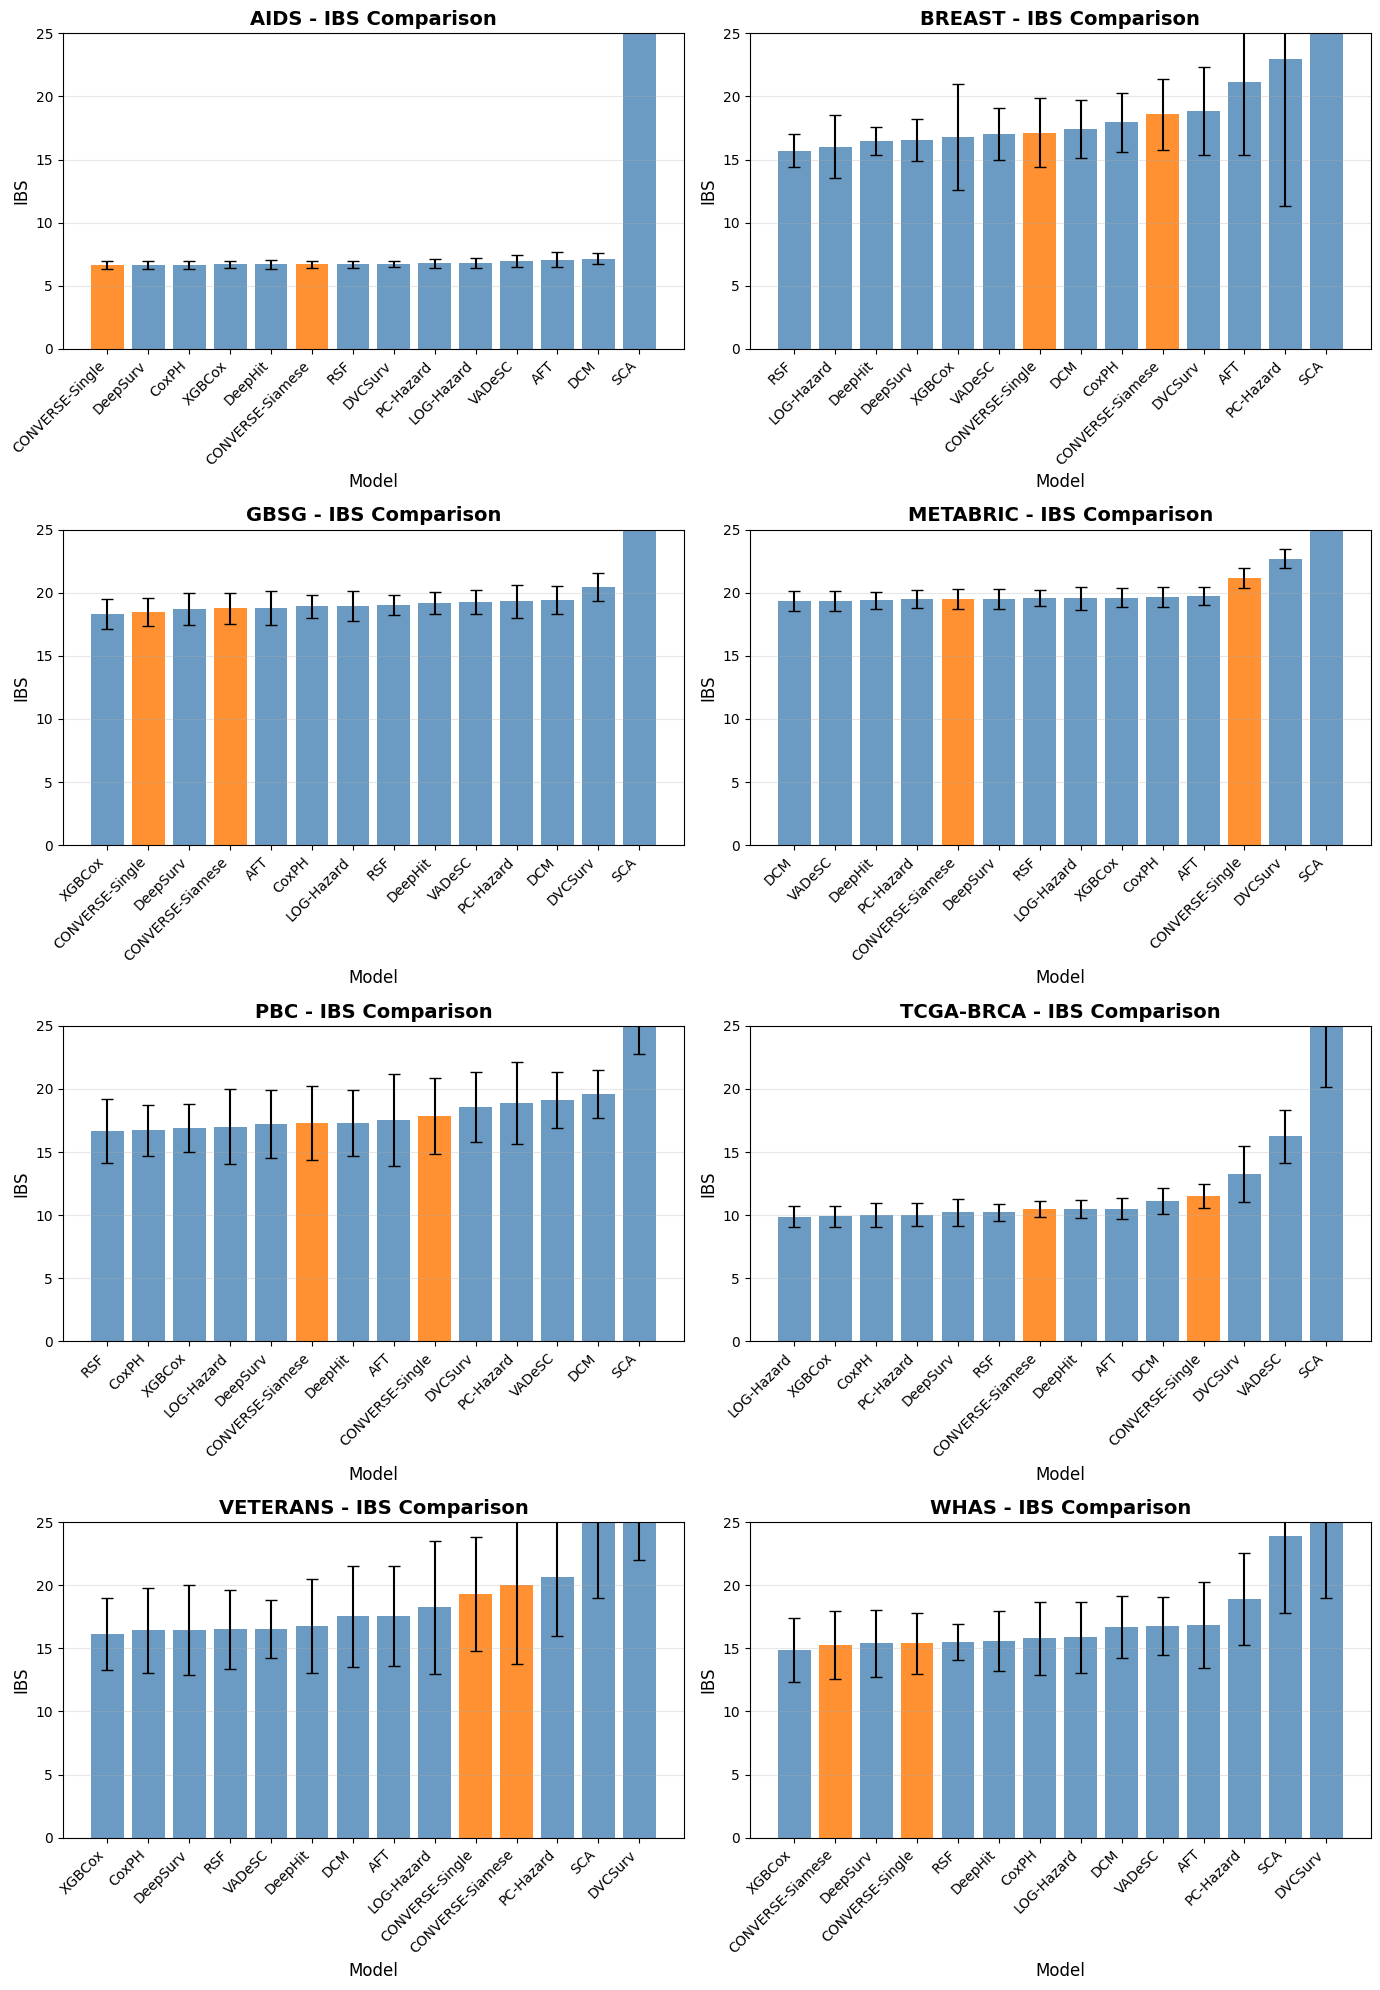

In [7]:
# IBS comparison: separate plots for each dataset (4x2 layout), test only
datasets = sorted(data['dataset'].unique())

n_cols = 2
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 20))
axes = axes.flatten()

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    df_subset = data[data['dataset'] == dataset].copy()

    # Sort models by test IBS performance (ascending)
    df_subset = df_subset.sort_values('test_ibs_mean', ascending=True)

    raw_models = df_subset['model'].values
    display_models = df_subset['model_display'].values
    dataset_label = df_subset['dataset_display'].iloc[0]

    x_pos = np.arange(len(display_models))

    # Color bars: converse models in orange, others in steelblue
    colors = ['#ff7600' if m in ['converse_single', 'converse_siamese'] else 'steelblue' for m in raw_models]

    # Plot test performance only (scaled by 100)
    ax.bar(x_pos, df_subset['test_ibs_mean'] * 100,
           yerr=df_subset['test_ibs_std'] * 100, label='Test', alpha=0.8, capsize=4, color=colors)

    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('IBS', fontsize=12)
    ax.set_title(f'{dataset_label} - IBS Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(display_models, rotation=45, ha='right')

    # Keep x-label highlighting for specific models
    for i, label in enumerate(ax.get_xticklabels()):
        model_name = raw_models[i]

    ax.set_ylim(0, 25)  # Clip IBS between 0 and 25
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Time Analysis

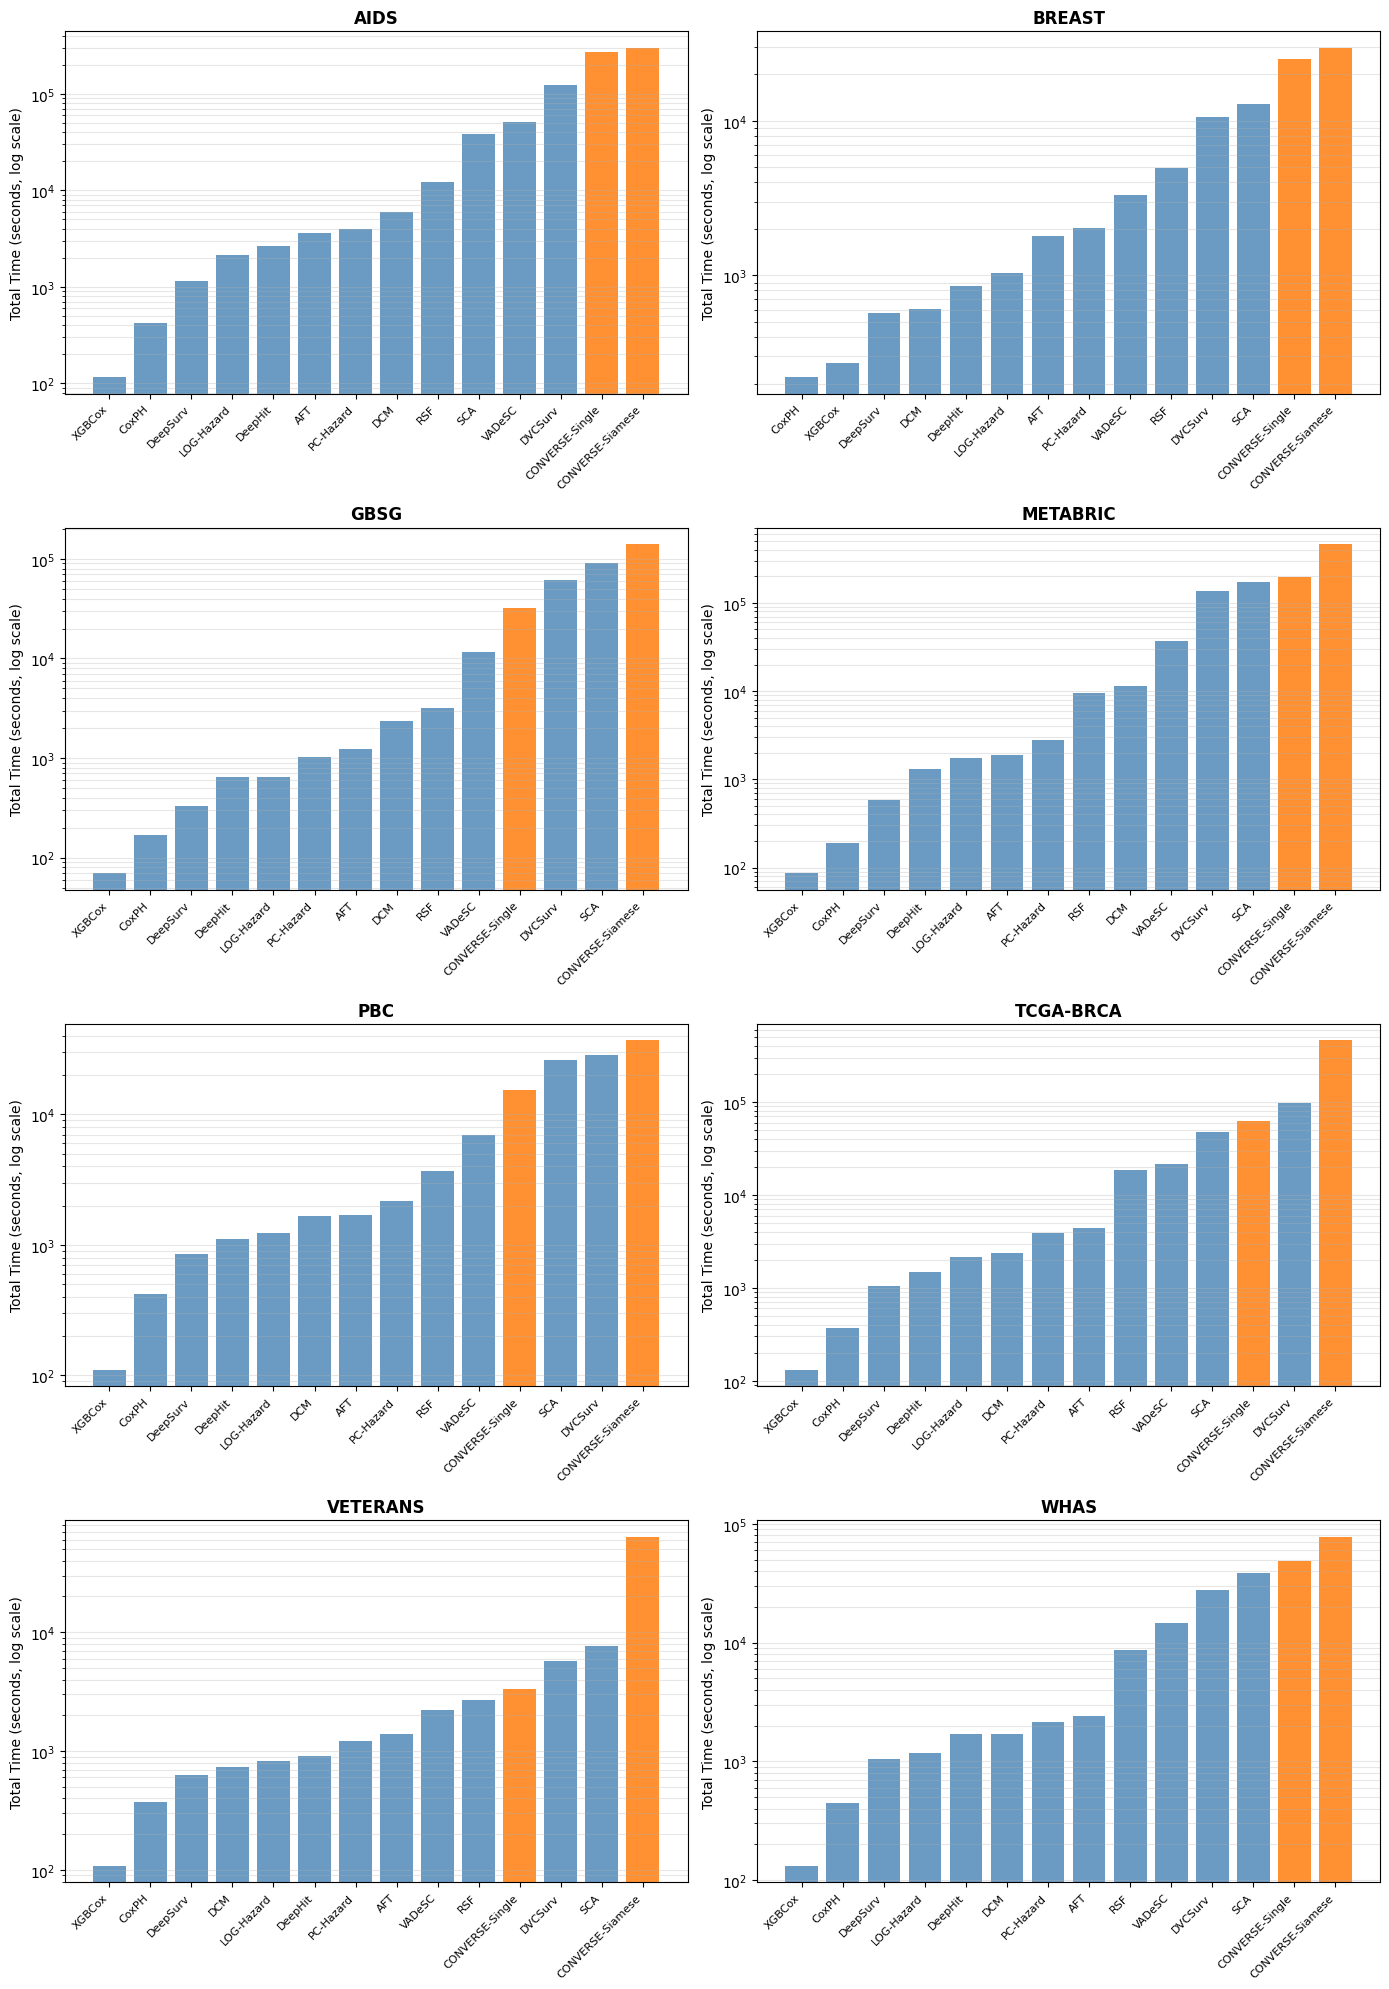

In [8]:
# Time comparison: separate plots for each dataset (4x2 layout)
n_cols = 2
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 20))
axes = axes.flatten()

for idx, dataset in enumerate(DATASETS):
    ax = axes[idx]
    df_subset = data[data['dataset'] == dataset].copy()

    # Sort models by total time (ascending - lower is better)
    df_subset = df_subset.sort_values('time_sec_total', ascending=True)

    # Get raw model IDs for logic and mapped names for display
    raw_models = df_subset['model'].values
    display_names = df_subset['model_display'].values
    dataset_label = df_subset['dataset_display'].iloc[0]

    x_pos = np.arange(len(raw_models))

    # Color bars: CONVERSE in pink/crimson, others in steelblue
    colors = ['#ff7600' if 'converse' in m else 'steelblue' for m in raw_models]

    # Plot total time in seconds with different colors
    ax.bar(x_pos, df_subset['time_sec_total'],
           label='Total Time', alpha=0.8, capsize=4, color=colors)

    # Added "log scale" note to Y label
    ax.set_ylabel('Total Time (seconds, log scale)', fontsize=10)
    ax.set_title(f'{dataset_label}', fontsize=12, fontweight='bold')

    # Set the ticks using mapped names
    ax.set_xticks(x_pos)
    ax.set_xticklabels(display_names, rotation=45, ha='right', fontsize=8)

    # Use logarithmic scale to show orders of magnitude differences
    ax.set_yscale('log')

    ax.grid(True, alpha=0.3, axis='y', which='both')

plt.tight_layout()
plt.show()

## Performance vs. Efficiency Trade-off Analysis

In [9]:
# Indicated if single or siamese configuration is the best one for that model
best_model_per_dataset = { 
    "aids": "converse_siamese",
    'breast_cancer': 'converse_single',
    'gbsg': 'converse_single',
    'metabric': 'converse_single',
    'pbc': 'converse_single',
    'tcga_brca': 'converse_siamese',
    'veterans': 'converse_single',
    'whas': 'converse_siamese'
}


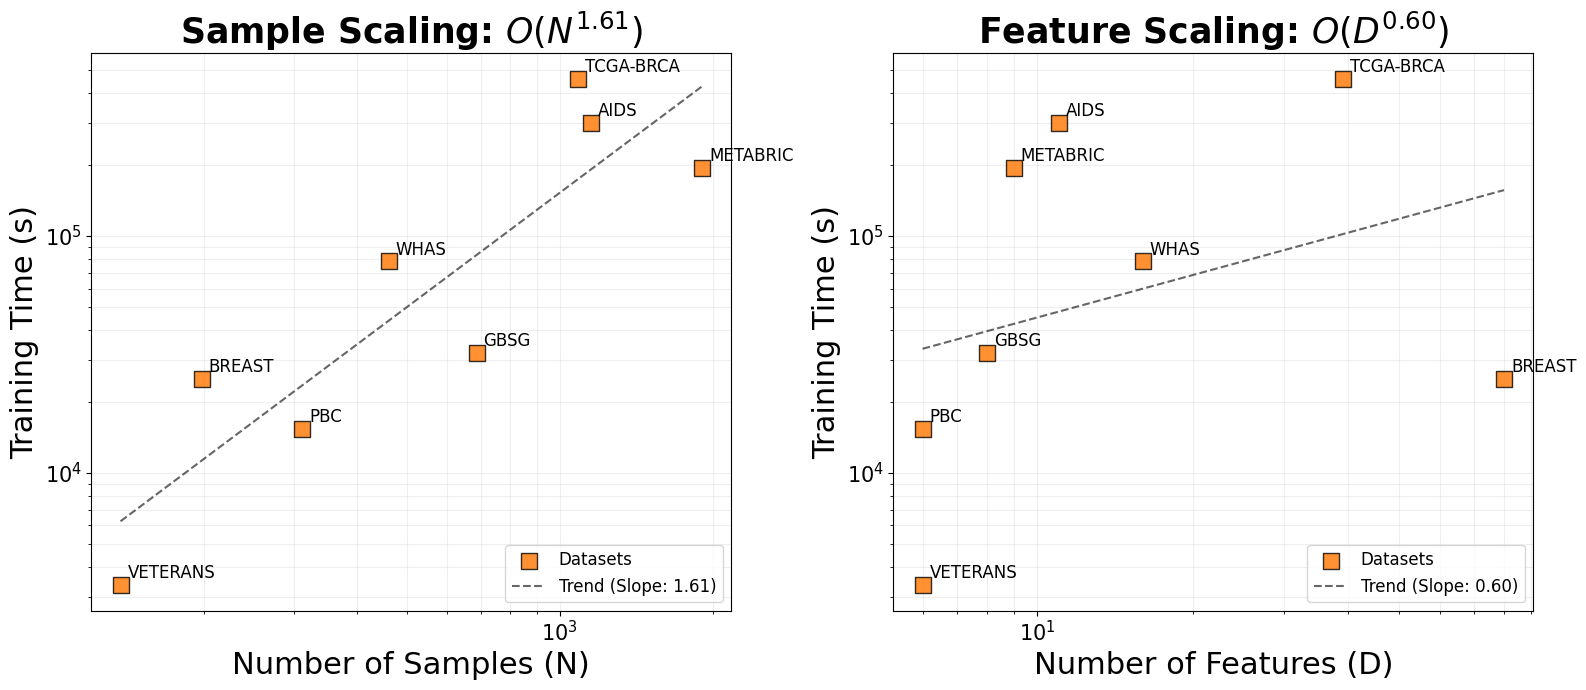

In [10]:
# 1. Filter for only the best CONVERSE model per dataset
mask = pd.Series([
    row['model'] == best_model_per_dataset.get(row['dataset'], '')
    for _, row in data.iterrows()
])
df_converse = data[mask].copy()

# 2. Map your dataset metadata (Ensure these match your actual data)
dataset_stats = {
    'aids': (1151, 11),
    'breast_cancer': (198, 80),
    'gbsg': (686, 8),
    'metabric': (1904, 9),
    'pbc': (312, 6),
    'tcga_brca': (1088, 39),
    'veterans': (137, 6),
    'whas': (461, 16)
}
df_converse['n_samples'] = df_converse['dataset'].map(lambda x: dataset_stats.get(x, (0, 0))[0])
df_converse['n_features'] = df_converse['dataset'].map(lambda x: dataset_stats.get(x, (0, 0))[1])

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 1: Scaling with Number of Samples ---
x1 = df_converse['n_samples'].values
y = df_converse['time_sec_total'].values
ax1.scatter(x1, y, color='#ff7600', s=120, edgecolors='black', alpha=0.8, label='Datasets', zorder=3, marker='s')

# Fit trend line in log-log space
log_x1, log_y = np.log10(x1), np.log10(y)
slope1, intercept1 = np.polyfit(log_x1, log_y, 1)

# Generate trend line points
x1_range = np.logspace(np.log10(x1.min()), np.log10(x1.max()), 100)
y1_trend = 10**(slope1 * np.log10(x1_range) + intercept1)

ax1.plot(x1_range, y1_trend, color='black', linestyle='--', alpha=0.6,
         label=f'Trend (Slope: {slope1:.2f})', zorder=2)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Number of Samples (N)', fontsize=22)
ax1.set_ylabel('Training Time (s)', fontsize=22)
ax1.set_title(f'Sample Scaling: $O(N^{{{slope1:.2f}}})$', fontsize=25, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.grid(True, which="both", alpha=0.2)
ax1.legend(loc="lower right", fontsize=12)


## --- Plot 2: Scaling with Feature Count ---
x2 = df_converse['n_features'].values
ax2.scatter(x2, y, color="#ff7600", s=120, edgecolors='black', alpha=0.8, label='Datasets', zorder=3, marker='s')

# Fit trend line in log-log space for features
log_x2 = np.log10(x2)
slope2, intercept2 = np.polyfit(log_x2, log_y, 1)

x2_range = np.logspace(np.log10(x2.min()), np.log10(x2.max()), 100)
y2_trend = 10**(slope2 * np.log10(x2_range) + intercept2)

ax2.plot(x2_range, y2_trend, color='black', linestyle='--', alpha=0.6,
         label=f'Trend (Slope: {slope2:.2f})', zorder=2)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Number of Features (D)', fontsize=22)
ax2.set_ylabel('Training Time (s)', fontsize=22)
ax2.set_title(f'Feature Scaling: $O(D^{{{slope2:.2f}}})$', fontsize=25, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid(True, which="both", alpha=0.2)
ax2.legend(loc="lower right", fontsize=12)

# Annotate dataset names on both
for ax, col in zip([ax1, ax2], ['n_samples', 'n_features']):
    for _, row in df_converse.iterrows():
        ax.annotate(row['dataset_display'],
                    (row[col], row['time_sec_total']),
                    xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.tight_layout()
plt.show()
